<table><tr>
<td> <img src=https://www.baltimorepolice.org/themes/custom/bpd/images/bpd_logo.png alt="Drawing" style="height: 250px;"/> </td>
<td> <img src=https://beam-images.warnermediacdn.com/BEAM_LWM_DELIVERABLES/1bc3aff5-0d6a-4c0b-8ed0-5716ca30ab3b/fbbc7a604f327cfa8a7bbe614a89be13a246d266.jpg?host=wbd-images.prod-vod.h264.io&partner=beamcom style="height: 250px;"/> </td>
</tr></table>

In [106]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
import statsmodels.api as sm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colors
from sklearn.preprocessing import label_binarize

Preprocesamiento de Datos
=

In [4]:
df = pd.read_csv('New_BPD.csv')

# Imputar valores nulos en 'Age' con la mediana
df['Age'] = df['Age'].fillna(df['Age'].median())

# Imputar valores nulos en 'Hour' con la mediana
df['Hour'] = df['Hour'].fillna(df['Hour'].median())

# Imputar valores nulos en 'District' con la moda
df['District'] = df['District'].fillna(df['District'].mode()[0])

# Eliminar filas con valores nulos en 'ChargeCategory'
df = df.dropna(subset=['ChargeCategory'])

# Codificar variables categóricas
label_encoder = LabelEncoder()
df['Sex'] = label_encoder.fit_transform(df['Sex'])
df['Race'] = label_encoder.fit_transform(df['Race'])
df['District'] = label_encoder.fit_transform(df['District'])
df['ChargeCategory'] = label_encoder.fit_transform(df['ChargeCategory'])

Entrenamiento del Modelo
=

In [6]:
# Selección de variables y target
X = df[['Age', 'Race']]
y = (df['ChargeCategory'] > 0).astype(int)  # Ejemplo para convertir en binario (1 si hay delito, 0 si no)

# Añadir constante para el modelo de regresión
X = sm.add_constant(X)

# Ajustar el modelo de regresión logística
model = sm.Logit(y, X).fit()

# Resumen del modelo
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.006348
         Iterations 12
                           Logit Regression Results                           
Dep. Variable:         ChargeCategory   No. Observations:                36782
Model:                          Logit   Df Residuals:                    36779
Method:                           MLE   Df Model:                            2
Date:                Wed, 07 Aug 2024   Pseudo R-squ.:                 0.01154
Time:                        03:14:16   Log-Likelihood:                -233.48
converged:                       True   LL-Null:                       -236.21
Covariance Type:            nonrobust   LLR p-value:                   0.06553
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.5316      0.612     10.679      0.000       5.333       7.730
Age            0.0315      0

Interpretación de los Coeficientes:
=
- const (Constante): 6.5316. Este es el intercepto del modelo. Es el valor del logit (logaritmo de las probabilidades) cuando todas las variables predictoras son 0.

- Age (Edad):
    - coef: 0.0315. Este coeficiente positivo sugiere que, a medida que la edad aumenta, también aumenta la probabilidad de pertenecer a una categoría de delitos (en la escala logit).
    - p-value: 0.085. Este valor indica que la edad no es un predictor significativamente fuerte (al nivel de significancia del 5%).
- Race (Raza):
    - coef: -0.2290. Este coeficiente negativo sugiere que la raza codificada con un valor más alto está asociada con una menor probabilidad de pertenecer a una categoría de delitos, en la escala logit.
    - p-value: 0.104. Este valor indica que la raza tampoco es un predictor significativamente fuerte (al nivel de significancia del 5%).
- Conclusión:
Los resultados indican que ni la edad ni la raza son predictores estadísticamente significativos para el modelo ajustado al 5% de nivel de confianza. Esto podría deberse a una baja correlación entre estas variables y la variable de respuesta ChargeCategory, o a que otros factores no considerados en el modelo juegan un papel más relevante.

Predicción de la categoría del delito (Modelo de clasificación multicategoría)
=

RandomForestClassifier

In [9]:
# Selección de variables y target
X = df[['Age', 'Sex', 'Race', 'District', 'Year', 'Month', 'DayOfWeek', 'Hour']]
y = df['ChargeCategory']

# División de los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Entrenamiento del modelo de Random Forest
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Predicción en el conjunto de prueba
y_pred = clf.predict(X_test)

# Reporte de clasificación
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.67      0.90      0.77      6496
           2       0.40      0.05      0.09        40
           3       0.32      0.08      0.12       932
           4       0.40      0.10      0.16       659
           5       0.54      0.16      0.25       206
           6       0.05      0.01      0.01       161
           7       0.45      0.36      0.40      2141
           8       0.39      0.11      0.17       392

    accuracy                           0.62     11035
   macro avg       0.36      0.20      0.22     11035
weighted avg       0.56      0.62      0.56     11035



Interpretación de los Resultados:
=
Para cada clase, los números se interpretan de la siguiente manera:

- Clase 0:
    - Support es muy bajo (solo 8 instancias en el conjunto de prueba), lo que puede ser la razón por la que el modelo tiene 0 en precisión, recall y f1-score. Probablemente el modelo no está aprendiendo bien para esta clase.
- Clase 1 (la clase más representada en los datos):
    - Precisión: 0.67. De todas las instancias predichas como clase 1, el 67% eran correctas.
    - Recall: 0.90. De todas las instancias reales de clase 1, el 90% fueron correctamente predichas.
    - F1-score: 0.77. Esta clase tiene un buen rendimiento general.
- Otras clases (2 a 8):
    - La precisión, recall y f1-score son generalmente bajos, especialmente en las clases con un bajo número de instancias (por ejemplo, la clase 2 tiene solo 40 instancias y un f1-score de 0.09).
    - El modelo tiene problemas para aprender y clasificar correctamente estas clases, especialmente las menos representadas.

Resumen General:
=
- Accuracy (Precisión general): 0.62, lo que significa que el modelo predijo correctamente el 62% de las instancias totales.

- Macro avg (Promedio macro): Calcula la media de precisión, recall y f1-score para todas las clases, sin considerar el desequilibrio en el número de instancias. Un f1-score de 0.22 sugiere un rendimiento general bajo cuando se considera cada clase de manera igualitaria.

- Weighted avg (Promedio ponderado): Calcula la media ponderada de precisión, recall y f1-score, teniendo en cuenta el soporte (número de instancias) de cada clase. Un f1-score de 0.56 refleja que el modelo tiene un rendimiento mejor en las clases más representadas (como la clase 1), pero en general tiene dificultades con las clases menos frecuentes.

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Selección de variables (X) y la variable objetivo (y)
X = df[['Age', 'Sex', 'Race', 'District', 'Year', 'Month', 'DayOfWeek', 'Hour']]
y = df['ChargeCategory']

# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Estandarizar las características (opcional, pero puede ayudar al modelo)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Entrenar el modelo de Regresión Logística Multinomial
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
model.fit(X_train_scaled, y_train)

# Calcular las probabilidades de cada clase para el conjunto de prueba
probabilities = model.predict_proba(X_test_scaled)

# Crear un DataFrame con los resultados
prob_df = pd.DataFrame(probabilities, columns=model.classes_)
prob_df['Predicted Class'] = prob_df.idxmax(axis=1)

In [182]:
print('0 : Administrative') 
print('1 : Drug Offenses')
print('2 : Other')
print('3 : Property Crimes')
print('4 : Public Order Crimes')
print('5 : Traffic Violations')
print('6 : Robbery')
print('7 : Violent Crimes')
print('8 : Weapons Violations')
prob_df.head()

0 : Administrative
1 : Drug Offenses
2 : Other
3 : Property Crimes
4 : Public Order Crimes
5 : Traffic Violations
6 : Robbery
7 : Violent Crimes
8 : Weapons Violations


,0,1,2,3,4,5,6,7,8,Predicted Class
0,0.001793,0.483656,0.003720,0.062230,0.125575,0.015276,0.032043,0.256497,0.019210,1
1,0.000913,0.516522,0.006348,0.066000,0.054480,0.033748,0.015262,0.224356,0.082370,1
2,0.000913,0.592549,0.004782,0.066193,0.077053,0.032504,0.015969,0.177926,0.032111,1
3,0.000077,0.635047,0.000857,0.124454,0.019589,0.003682,0.010569,0.168427,0.037297,1
4,0.001122,0.314357,0.001247,0.083296,0.126070,0.003340,0.022349,0.441441,0.006778,7


In [14]:
# Quitamos el limite de visualización de filas
pd.set_option('display.max_rows', None)
prob_df['Predicted Class'].value_counts()

Predicted Class
1    10548
7      487
Name: count, dtype: int64

Conclusión:
=
- Este resultado muestra cómo el modelo asigna probabilidades a cada clase de delito para cada detenido en el conjunto de datos de prueba. La Predicted Class es la clase con la probabilidad más alta para cada observación, lo que el modelo considera como el delito más probable que el detenido ha cometido.

- Si la Predicted Class coincide con la clase real del delito en el conjunto de prueba, eso indica que el modelo hizo una predicción correcta.
Las probabilidades también te permiten entender el grado de certeza que el modelo tiene sobre cada predicción. Por ejemplo, si una fila tiene probabilidades muy cercanas entre varias clases, eso indica una mayor incertidumbre en la predicción.

MATRIZ DE CONFUSIÓN:
=

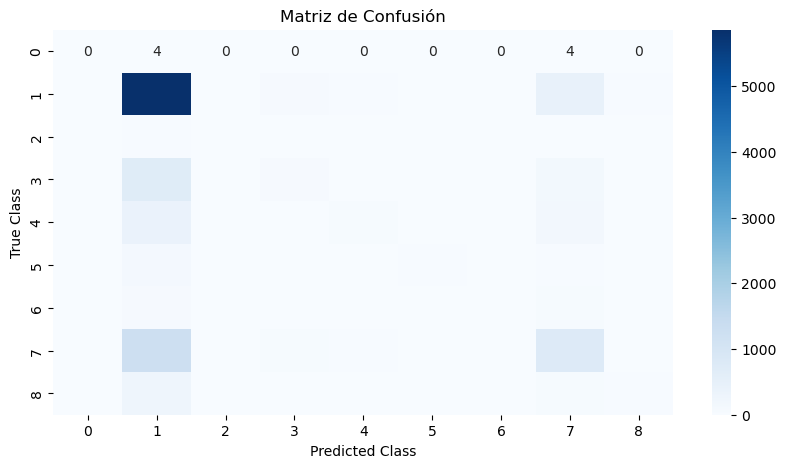

In [34]:
# Construir la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Paso 3: Visualizar la matriz de confusión
plt.figure(figsize=(10, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Matriz de Confusión')
plt.show()

In [16]:
print(cm)

[[   0    4    0    0    0    0    0    4    0]
 [   1 5860    2   81   40    7    8  457   40]
 [   0   32    2    0    1    0    0    5    0]
 [   0  698    0   72   10    4    2  144    2]
 [   0  407    0   11   67    3    3  166    2]
 [   0  116    0    3    1   33    2   42    9]
 [   0   87    0    4    6    0    1   61    2]
 [   0 1266    1   51   37    5    5  763   13]
 [   0  279    0    4    7    9    1   48   44]]


Interpretación:
=
- Ejes: Las filas de la matriz de confusión representan las clases reales, mientras que las columnas representan las clases predichas.

- Celdas: Cada celda muestra el número de instancias que pertenecen a la combinación correspondiente de clase real y predicha. Las celdas en la diagonal (de arriba a la izquierda a abajo a la derecha) representan predicciones correctas. Las celdas fuera de la diagonal representan errores.

- Colores: Los colores en el heatmap indican la magnitud de los valores; cuanto más oscuro el color, mayor es el valor. Esto te permite identificar visualmente patrones en las predicciones.

MATRIZ DE CONFUSIÓN POR DELITO
=

0 : Administrative
1 : Drug Offenses
2 : Other
3 : Property Crimes
4 : Public Order Crimes
5 : Traffic Violations
6 : Robbery
7 : Violent Crimes
8 : Weapons Violations


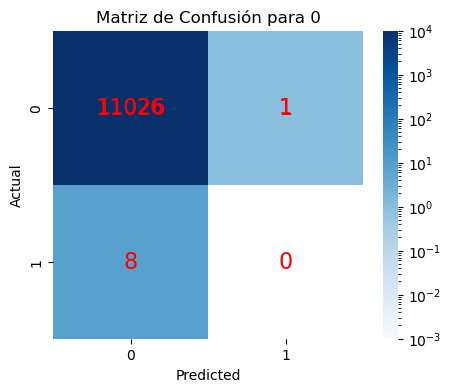

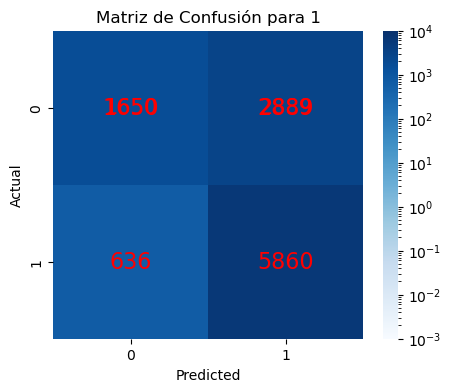

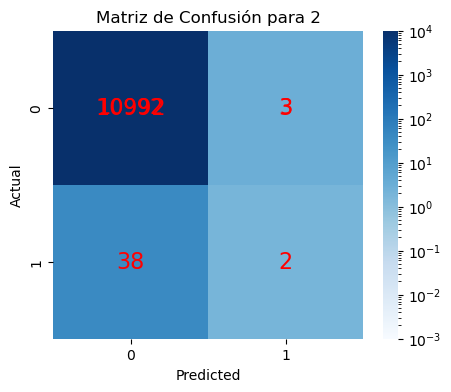

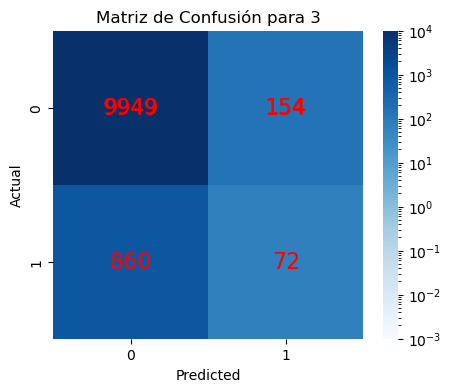

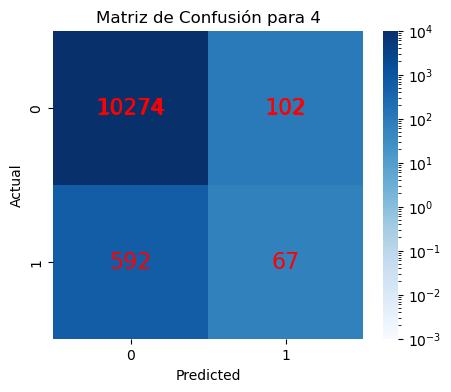

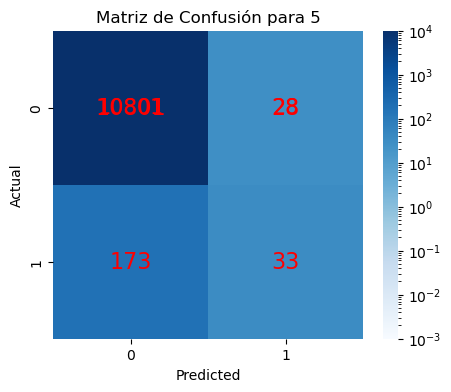

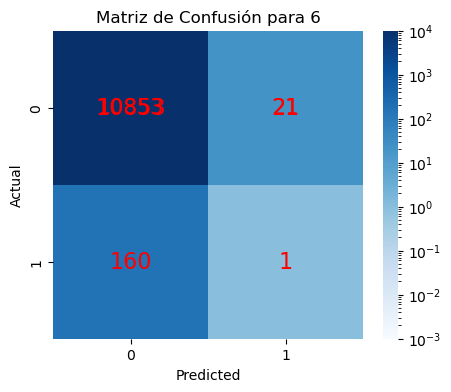

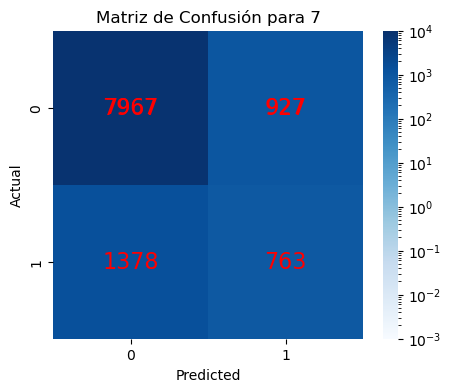

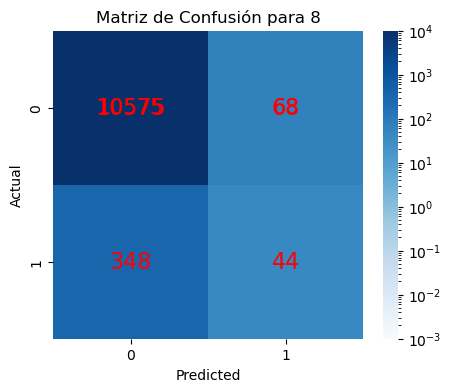

In [198]:
print('0 : Administrative') 
print('1 : Drug Offenses')
print('2 : Other')
print('3 : Property Crimes')
print('4 : Public Order Crimes')
print('5 : Traffic Violations')
print('6 : Robbery')
print('7 : Violent Crimes')
print('8 : Weapons Violations') 
classes = model.classes_
for i, class_label in enumerate(classes):
    # Binarizar las etiquetas reales y las predicciones
    y_test_bin = (y_test == class_label).astype(int)
    y_pred_bin = (y_pred == class_label).astype(int)

    # Crear la matriz de confusión 2x2
    cm = confusion_matrix(y_test_bin, y_pred_bin)
    # Visualizar la matriz de confusión
    plt.figure(figsize=(5, 4))
    ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True, annot_kws={"size": 15, "color": 'red'}, norm=colors.LogNorm(vmin=0.001, vmax=10000))
    # Añadir anotaciones manualmente
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j + 0.5, i + 0.5, cm[i, j], 
                    ha='center', va='center', 
                    color='red', fontsize=16)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Matriz de Confusión para {class_label}')
    plt.show()

Interpretación General
=
1. Altos VP y Bajos FN:

    - Para la clase 0, 2, 3, 4, 5, 6, y 8, los valores de verdaderos positivos son altos y los falsos negativos son relativamente bajos, lo que indica que el modelo tiene un buen rendimiento para estas clases.
2. Bajos VP y Altos FN:

    - Para la clase 1 y la clase 7, los verdaderos positivos son menores y los falsos negativos son más altos, lo que indica que el modelo tiene dificultades para identificar correctamente estas clases, ya que se confunden con otras clases.
3. Falsos Positivos y Verdaderos Negativos:

    - Las clases con altos falsos positivos (FP) indican que el modelo tiende a clasificar incorrectamente algunos ejemplos como esa clase cuando no lo son. Por ejemplo, en la clase 1, el número de falsos positivos es alto.
4. Imbalance en las Clases:

    - Algunos números de verdaderos negativos (VN) son bajos, indicando que puede haber un desequilibrio en la representación de las clases, especialmente en casos con muchas categorías de salida (por ejemplo, la clase 7 tiene muchos falsos positivos).